In [1]:
# import packages
import os, gc
from datetime import datetime
import pathlib
import zarr
import numpy as np 
import pandas as pd 
import timm
from tqdm import tqdm

from typing import Dict
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# L5kit imports
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, write_gt_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.visualization.gif import write_gif
from prettytable import PrettyTable
from pathlib import Path

# Load Models

import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader

In [2]:
DATA_PATH = "../Motion_prediction_model_for_self_driving/input"
os.environ["L5KIT_DATA_FOLDER"] = DATA_PATH
dm = LocalDataManager(None)

# Get respective configuration for training
cfg = load_config_data("configs/baseline_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 20, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': True, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 1}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 32, 'shuffle': False, 'num_workers': 1}, 'sample_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 32, 'shuffle': False, 'num_workers': 1}, 'train_params': {'checkpoint_every_n_steps': 5000, 'max_num_steps': 20000, 'eval_every_n_steps': 5000}}


In [3]:
# Initialize Sample set
train_cfg = cfg["sample_data_loader"]
rasterizer = build_rasterizer(cfg, dm)

In [4]:
sample_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()


In [31]:
len(sample_zarr.scenes)

sample_zarr.frames[247]

(1572643709501466586, [21224, 21309], [0, 0], [  859.51696777, -1911.6027832 ,   284.0980835 ], [[ 0.54578024, -0.83336717,  0.08731023], [ 0.83377475,  0.55048066,  0.04231732], [-0.08332846,  0.04970111,  0.99528193]])

In [32]:
sample_dataset = AgentDataset(cfg, sample_zarr, rasterizer)
# sample_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
#                              num_workers=train_cfg["num_workers"])
# print(sample_dataloader)

In [33]:
tr_it = iter(sample_dataset)



In [34]:
data = next(tr_it)
print(data["frame_index"])

11


In [35]:
data.keys()

dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'curr_speed', 'scene_index', 'host_id', 'timestamp', 'track_id'])

In [39]:
print(np.min(data["image"]))
print(np.max(data["image"]))
print(len(data["image"]))

0.0
1.0
45


(45, 224, 224)


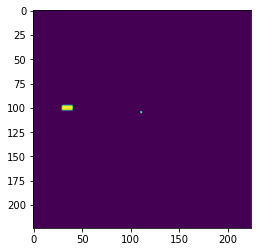

(45, 224, 224)


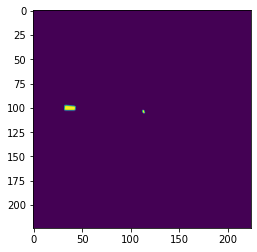

(45, 224, 224)


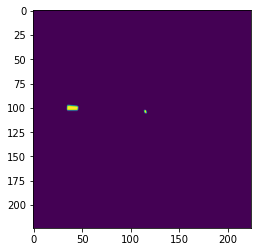

(45, 224, 224)


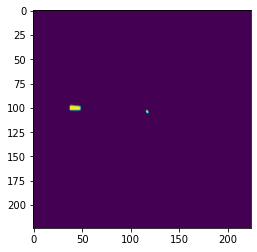

(45, 224, 224)


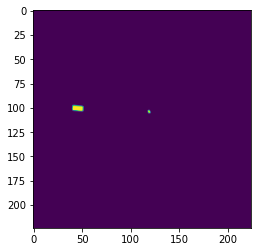

(45, 224, 224)


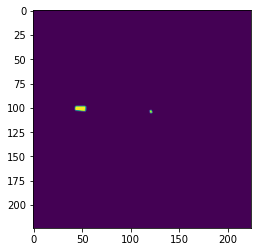

(45, 224, 224)


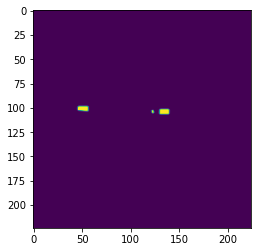

(45, 224, 224)


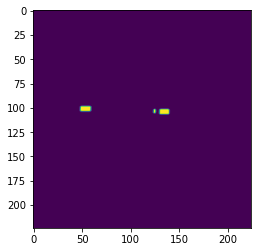

(45, 224, 224)


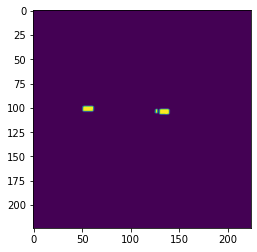

(45, 224, 224)


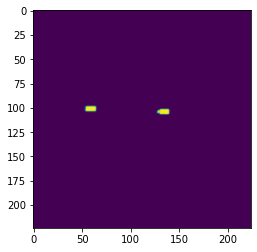

(45, 224, 224)


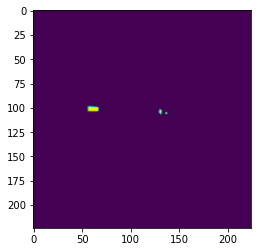

(45, 224, 224)


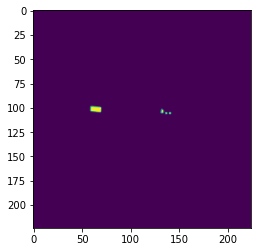

(45, 224, 224)


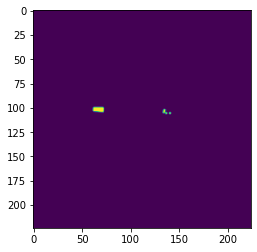

(45, 224, 224)


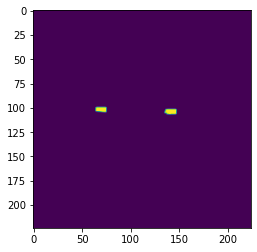

(45, 224, 224)


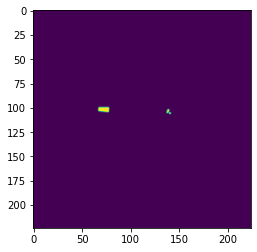

(45, 224, 224)


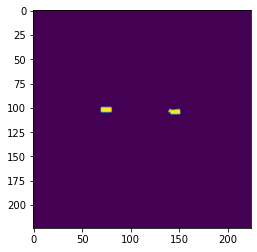

(45, 224, 224)


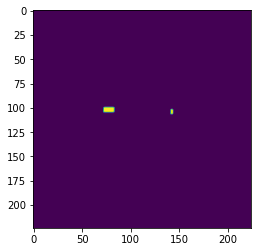

(45, 224, 224)


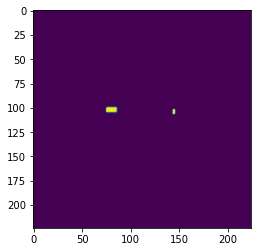

(45, 224, 224)


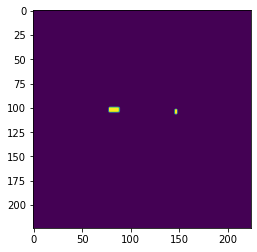

(45, 224, 224)


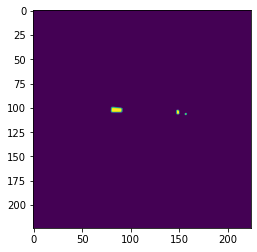

(45, 224, 224)


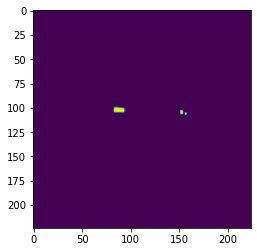

(45, 224, 224)


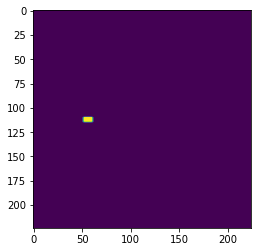

(45, 224, 224)


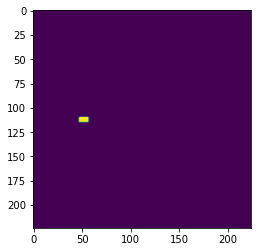

(45, 224, 224)


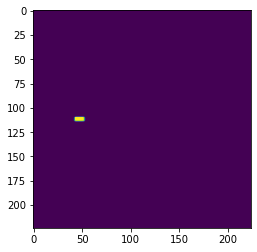

(45, 224, 224)


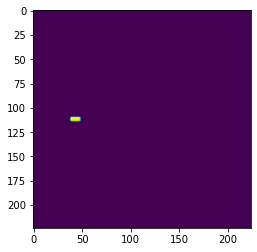

(45, 224, 224)


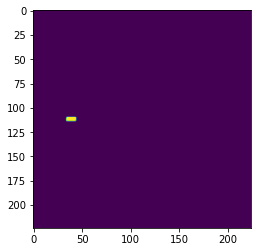

(45, 224, 224)


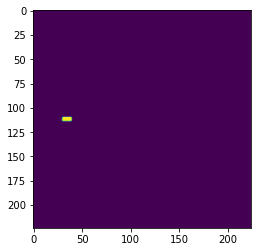

(45, 224, 224)


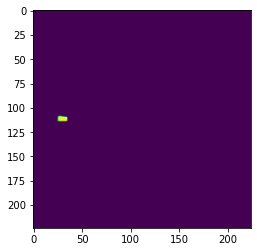

(45, 224, 224)


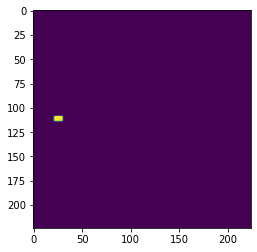

(45, 224, 224)


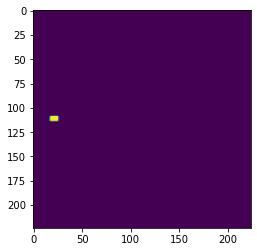

(45, 224, 224)


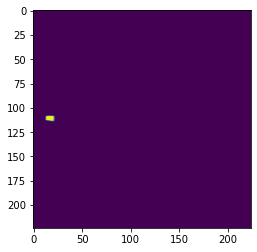

(45, 224, 224)


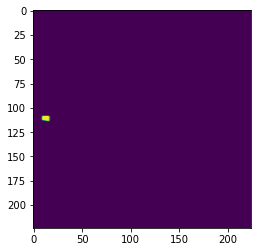

(45, 224, 224)


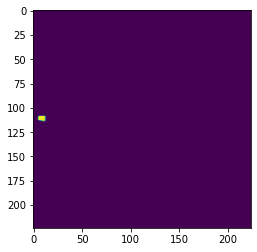

(45, 224, 224)


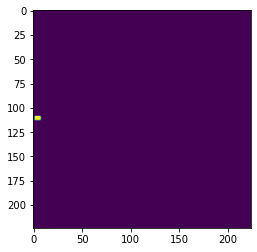

(45, 224, 224)


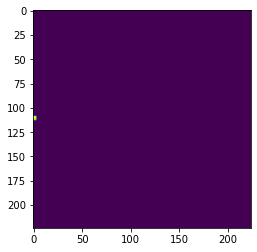

(45, 224, 224)


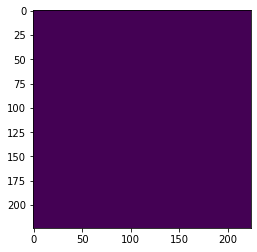

(45, 224, 224)


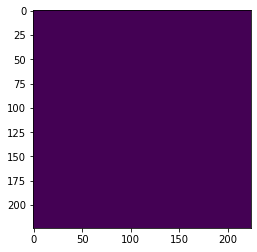

(45, 224, 224)


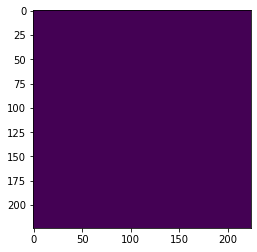

(45, 224, 224)


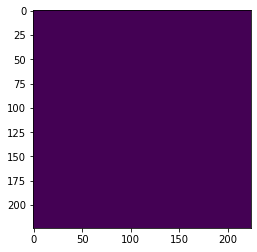

(45, 224, 224)


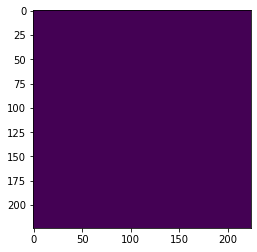

(45, 224, 224)


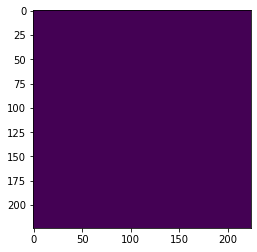

(45, 224, 224)


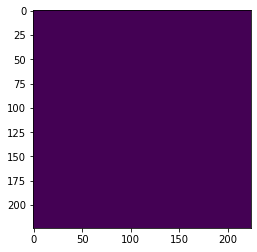

(45, 224, 224)


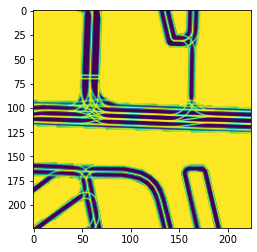

(45, 224, 224)


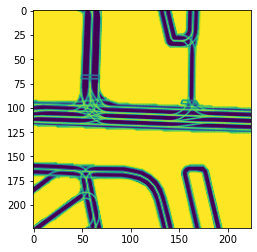

(45, 224, 224)


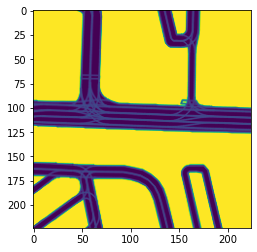

(45, 224, 224)


IndexError: index 45 is out of bounds for axis 0 with size 45

In [134]:
for i in range(46):

#     data = next(tr_it)

    print(data["image"].shape)
    
    plt.imshow(data["image"][i])
    plt.show()

(25, 224, 224)


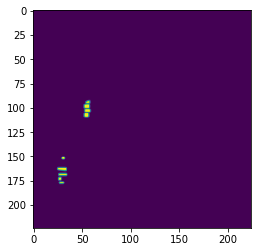

(25, 224, 224)


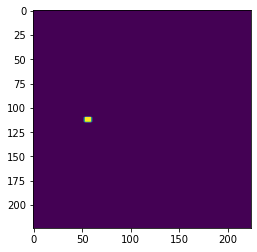

(25, 224, 224)


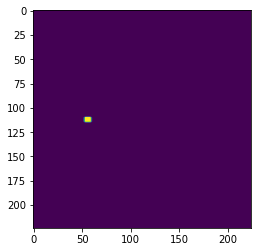

(25, 224, 224)


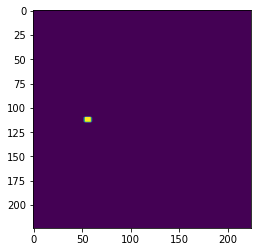

(25, 224, 224)


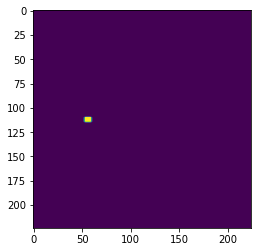

(25, 224, 224)


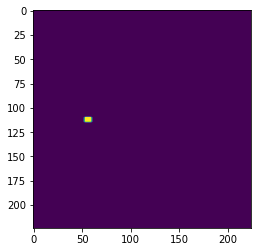

(25, 224, 224)


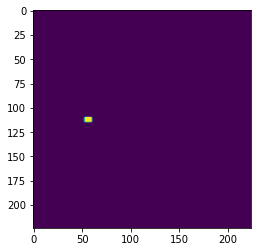

(25, 224, 224)


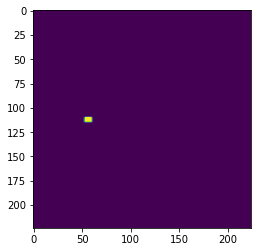

(25, 224, 224)


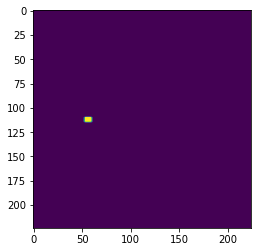

(25, 224, 224)


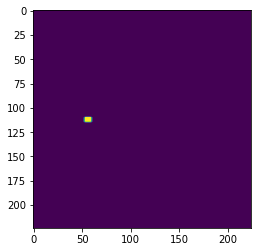

(25, 224, 224)


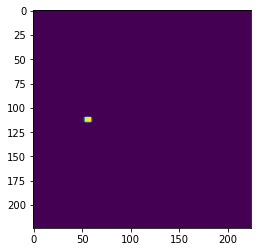

In [71]:
for i in range(11):

#     data = next(tr_it)
    i+=10
    print(data["image"].shape)
    
    plt.imshow(data["image"][i])
    plt.show()

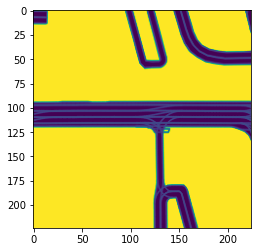

In [63]:
plt.imshow(data["image"][24])
plt.show()

In [5]:
print(np.asarray((244,244))*(0.5,0.5))

[122. 122.]


In [6]:
img= 255 * np.ones(shape=(244, 244, 3), dtype=np.uint8)

(244, 244, 3)
